# Data Engineering and Feature Selection

In this notebook, we explore the 780 features provided in the dataset. We first show evidence that the features are highly correlated; then we use hierarchical clustering to cluster the highly correlated features. The result is 174 clusters.

In [1]:
# libraries and settings
import gc
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import linkage, fcluster, leaves_list
from scipy.spatial.distance import squareform
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_parquet('../data/input/train.parquet')

In [3]:
#finding the correlation between features
X_cols = df_train.columns[df_train.columns.str.startswith('X')]
corr = np.corrcoef(df_train[X_cols].to_numpy(), rowvar=False)  # → 780×780 matrix

In [4]:
# extract only upper-triangular off-diagonal values
i, j = np.triu_indices_from(corr, k=1)
corr_vals = abs(corr[i, j])

### Density plot of pairwise feature correlations
The following plot shows the density of the pairwise absolute correlation between pairs of features. As we can see the histogram has a fat righ tail, indicating groups of highly correlated features.

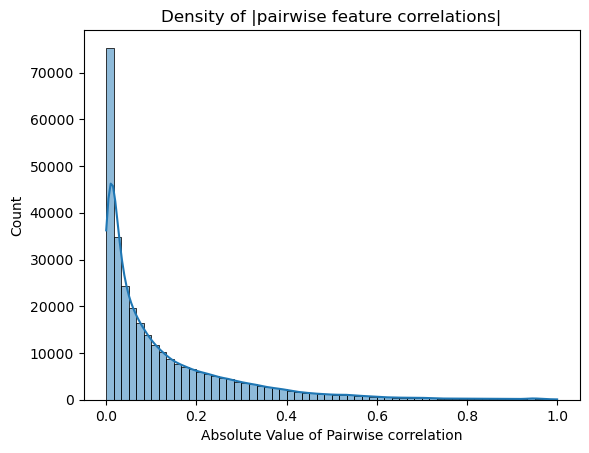

In [16]:
sns.histplot(corr_vals, bins=60, kde=True)
plt.xlabel("Absolute Value of Pairwise correlation")
plt.ylabel("Count")
plt.title("Density of |pairwise feature correlations|")
plt.show()

### Correlation heatmap

As another piece of evidence, we first cluster the features hierachically based on the distance function defined as: 1 - |correlation|. Next, we reorder the features so that those in one cluster appear closer to each other, and plot the absolute value of the correlations on a heatmap. The cluster of correlated features can be seen as red squares around the diagonal.

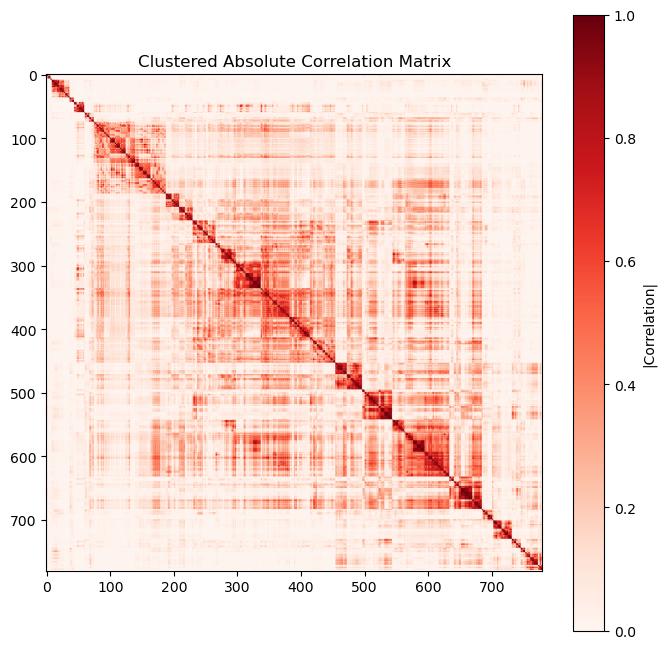

In [11]:
# 1) Hierarchical clustering on the correlation matrix
corr_abs = np.abs(corr)
dist = 1 - corr_abs
dist = (dist + dist.T) / 2 # make sure the dist matrix is exactly symmetric
np.fill_diagonal(dist, 0) # make sure the diagonals are exactly 0
condensed_dist = squareform(dist) 

Z = linkage(condensed_dist, method='average')

# 2) reorder of features after clustering
order = leaves_list(Z)
corr_reordered = corr_abs[order][:, order]

plt.figure(figsize=(8, 8))
plt.imshow(corr_reordered, cmap='Reds', vmin=0, vmax=1)
plt.colorbar(label="|Correlation|")
plt.title("Clustered Absolute Correlation Matrix")
plt.show()

### Hierarchical clustering

We use hierarchial clustering based on the distance explained above to cluster the features; we set the distance threshold for the clustering to 0.3. This will result in 174 clusters. We later use these clusters in two different prediction strategies: in one, we take the average of all features in a cluster, giving us 174 new features, which are used in an ensemble lgbm model. In the second one, we keep sampling features from different clusters, so that we don;t have two features from one cluster at a time, and train lgbms on each of those feature subsets, and stack them in an ensemble model.

In [12]:
# save the clusters
cluster_labels = fcluster(Z, t=0.3, criterion='distance')

# create new column labels based on the clustering
col2cluster = pd.Series([f'Y{i}' for i in cluster_labels], index = X_cols)
col2cluster.to_csv('../data/intermediate/clusters.csv', index = True)